# Curtain Parallel Potential Model
Here I explore the minimum parallel electric potential necessary to lower the mirror point of an electron from 100 km in the SAA (just trapped), to AC6's altitude in the bounce loss cone. 

Further, we assume this potential is at the equator, so it will modify the electron's equatorial pitch angle.

We will first pick a curtain observation and use IRBEM to find the minimum altitude and pitch angle change those electrons experienced such that they were observed by AC6 for a prolonged period.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.interpolate
import dateutil.parser
import pathlib

import IRBEM
Re_km = 6_371

In [152]:
# t_0 = datetime(2015, 8, 27, 23, 4, 44, 500000)

curtain_times = [
                '2016-10-29T01:21:38.400000', # Good (at midnight, AE=787) 1.8 kV
                '2015-07-27T10:38:16.500000', # Good (10 MLT, AE=587) 2.5 kV
                '2016-09-26T00:11:57.400000', # Good (midnight, AE=581) 2 kV
                '2015-08-27T23:04:37.700000', # Good (midnight, AE=745) 4.4 kV
                ]

t_0 = dateutil.parser.parse(curtain_times[3])

### Load data to look up AC6 location

In [153]:
cat_path = (f'/home/mike/research/ac6/ac6a/ascii/level2/AC6-A_'
            f'{datetime.strftime(t_0, "%Y%m%d")}_L2_10Hz_V03.csv')
# cat = pd.read_csv(cat_path, index_col=0)
# cat.index = pd.to_datetime(cat.index)
# cat.head()

cat = pd.read_csv(cat_path, na_values='-1e+31')
cat['dateTime'] = pd.to_datetime(
    cat[['year', 'month', 'day', 'hour', 'minute', 'second']])
cat.index = cat['dateTime']

In [154]:
curtain_obs_params = cat.loc[t_0]
curtain_obs_params

year                                            2015
month                                              8
day                                               27
hour                                              23
minute                                             4
second                                          37.7
alt                                          685.426
lat                                           59.422
lon                                          2.21572
dos1l                                             42
dos1m                                            247
dos1rate                                     900.005
dos2l                                            189
dos2m                                            121
dos2rate                                           0
dos3l                                            226
dos3m                                            201
dos3rate                                           0
flag                                          

From a single spacecraft this looks like two superposed microbursts
![image](20150827_blc_curtain_example.png)

### BLC Sanity Check
Southern Hemisphere Mirror Point For Locally Mirroring Electrons at AC6 

In [155]:
model = IRBEM.MagFields(kext='OPQ77')
X = {'dateTime':t_0, 'x1':cat.loc[t_0, 'alt'], 'x2':cat.loc[t_0, 'lat'], 'x3':cat.loc[t_0, 'lon']}

try:
    model.mirror_point_altitude(X, None)
    print(model.mirrorAlt)
except ValueError as err: 
    if str(err) == 'Mirror point below the ground!':
        print(err)
    else:
        raise

Mirror point below the ground!


Looks like the mirror point in the southern hemisphere is below the ground - I am very confident that these electrons must have been lost within one bounce.

### Mirror points for trapped particles
Trace the field line connected to AC6 and find the mirror point altitude above AC6 of bareley trapped electrons - defined as electrons with a 100 km mirror point altitude in the SAA.

In [156]:
output_dictionary = model.trace_field_line(X, None) # Trace the magnetic field line.
field_line_dict = {'x':output_dictionary['POSIT'][:,0], 'y':output_dictionary['POSIT'][:,1], 
              'z':output_dictionary['POSIT'][:,2], 'blocal':output_dictionary['blocal'],
             'alt':Re_km*(np.linalg.norm(output_dictionary['POSIT'], axis=1)-1)}
field_line_df = pd.DataFrame(data=field_line_dict)
interp_index = np.linspace(0, len(output_dictionary['POSIT'][:,0])-1, num=10000)

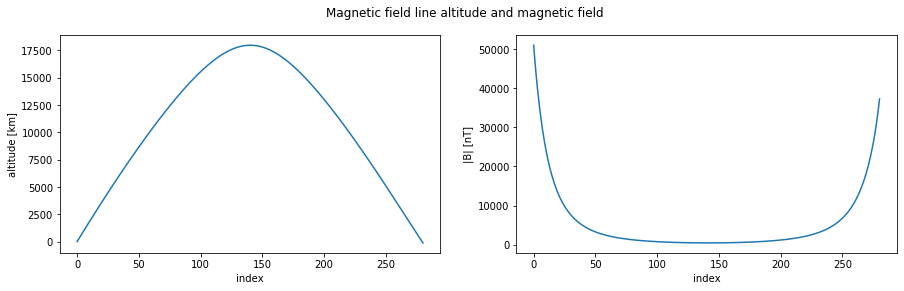

In [157]:
_ , ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(field_line_df.alt); ax[0].set(xlabel='index', ylabel='altitude [km]')
ax[1].plot(field_line_df.blocal); ax[1].set(xlabel='index', ylabel='|B| [nT]')
plt.suptitle('Magnetic field line altitude and magnetic field');

Interpolate the field line values

In [158]:
def interp_df(df, new_index):
    """
    Return a new DataFrame with all columns values interpolated
    to the new_index values.
    """
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col, right=np.nan)

    return df_out

field_line_interp = interp_df(field_line_df, interp_index)

### Find the magnetic field strength at 100 km in the southern hemisphere and estimate by how much the electron's mirror point must have lowered

In [159]:
southern_mp_trapped = field_line_interp[field_line_interp.alt > 100].iloc[-1]
southern_mp_trapped

x             0.454604
y             0.310692
z            -0.853467
blocal    33776.131018
alt         100.026822
Name: 278.6838683868387, dtype: float64

Now use the local b field at 100 km altitude in the SAA to find the altitude in the northern hemisphere that has the same magnetic field strength

In [160]:
northern_mp_trapped = field_line_interp[field_line_interp.blocal < southern_mp_trapped.blocal].iloc[0]
northern_mp_trapped

x             0.602129
y             0.023878
z             0.982623
blocal    33730.875249
alt         972.796057
Name: 5.292529252925292, dtype: float64

Now find out the difference in altitude - by how much the electron's mirror point needed to lower in one bounce and be observed by AC6

In [161]:
ac6_blocal = field_line_interp[field_line_interp.alt > curtain_obs_params.alt].iloc[0].blocal
print(f"The electron's mirror point must have decreased by at least "
      f"{round(northern_mp_trapped.alt - curtain_obs_params.alt)} km "
      f"into a {round(ac6_blocal - northern_mp_trapped.blocal)} nT stronger field strength")

The electron's mirror point must have decreased by at least 287.0 km into a 4240.0 nT stronger field strength


### Estimate the change in pitch angle from the trapped to the precipitating particle.
First find the equatorial magnetic field strength

In [162]:
b_equator = model.find_magequator(X, None)['bmin']
print(f'Equatorial magnetic field strength = {round(b_equator)} nT')

Equatorial magnetic field strength = 474 nT


The equatorial pitch angle is defined as 

$$
\alpha_{eq} = sin^{-1} \bigg( \sqrt{ \frac{ B_{eq} } { B_m } } \bigg)
$$

In [163]:
alpha_initial = np.arcsin(np.sqrt(b_equator/southern_mp_trapped['blocal']))
alpha_final = np.arcsin(np.sqrt(b_equator/ac6_blocal))
d_alpha = alpha_initial - alpha_final

print(f"Initial pitch angle = {round(np.rad2deg(alpha_initial), 2)} degrees")
print(f"Final pitch angle = {round(np.rad2deg(alpha_final), 2)} degrees")
print(f"Pitch angle change = {round(np.rad2deg(d_alpha), 2)} degrees")

Initial pitch angle = 6.81 degrees
Final pitch angle = 6.42 degrees
Pitch angle change = 0.39 degrees


Now find the parallel potential (I worked out the math on paper).

In [164]:
potential = 35E3 * np.cos(alpha_initial) * ((np.tan(alpha_initial)/np.tan(alpha_final))**2 - 1)
print(f'Minimum electric potential is {round(potential)} Volts')

Minimum electric potential is 4378.0 Volts


Paul's idea to use adiabatic invariants. Kinetic energy of a prticle at the mirror point is $W=\mu B_0$ with no potential. Then you accelerate the particle with a potential $\Phi$ and the particle will keep going until it reaches a new mirror point at $\mu B_1 = \mu B_0 + q \Phi$. Then the potential is just

$$
q\Phi = \frac{W}{B_0} (B_1 - B_0),
$$ where $W$ is the electron's kinetic energy.

In [165]:
35E3*(ac6_blocal - northern_mp_trapped.blocal)/northern_mp_trapped.blocal

4399.932260302159

# Misc

### 35 keV electron bounce period in the area near the BLC
Calculate the bounce period for locally mirroring, 35 keV electrons near the BLC region. This is only an appriximation to see if the bounce period is anywhere near the 4-8 second AC6 in-track separations when these curtains were observed.

In [166]:
X = {'dateTime':t_0, 'x1':cat.loc[t_0, 'alt'], 'x2':cat.loc[t_0, 'lat'], 'x3':-30}
model.bounce_period(X, None, 35)
print(f'35 keV electron bounce period is {round(model.Tb, 2)} seconds')

35 keV electron bounce period is 1.53 seconds
